In [9]:
import numpy as np
from scipy import signal as sgl
from matplotlib import pyplot as plt
import numba
import matplotlib as mpl
import time
mpl.rcParams['font.size'] = 20

In [10]:
@numba.njit
def simulate_heun_noise(parameters, length: int = 302, dt: int = 1, num_sim: int = 2000, initial_conditions = np.array([0.25,0.25]), noise_seed: int = 42):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Set seet
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-1]), np.sqrt(2*params[-2])
    # Equivalent to allocating memory
    time_series_E = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_I = np.empty((int(1000/dt*length),int(num_sim)))
    time_series_E_temp = np.empty((1,int(num_sim)))
    time_series_I_temp = np.empty((1,int(num_sim)))
    time_series_E_corr = np.empty((1,int(num_sim)))
    time_series_I_corr = np.empty((1,int(num_sim)))
    time_series_E_noise = np.empty((1,int(num_sim)))
    time_series_I_noise = np.empty((1,int(num_sim)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        # Forward Euler
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[i] + params[18] - params[9]
        time_series_I[i+1] = params[1] * time_series_E[i] - params[3] * time_series_I[i] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7])))
        time_series_I[i+1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[i+1] - params[11])))
        time_series_E[i+1] = dt*(((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[i+1] = dt*(((params[17] - params[15] * time_series_I[i]) * time_series_I[i+1]) - time_series_I[i]) / params[5] 
        time_series_E_noise = np.random.normal(0,1,size=num_sim) *  DE
        time_series_I_noise = np.random.normal(0,1,size=num_sim) *  DI
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] + time_series_E_noise
        time_series_I_temp = time_series_I[i] + time_series_I[i+1] + time_series_I_noise
        # Corrector point
        time_series_E_corr = params[0] * time_series_E_temp - params[2] * time_series_I_temp + params[18] - params[9]
        time_series_I_corr = params[1] * time_series_E_temp - params[3] * time_series_I_temp + params[19] - params[13]
        time_series_E_corr = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E_corr - params[7])))
        time_series_I_corr = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I_corr - params[11])))
        time_series_E_corr = dt*(((params[16] - params[14] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        time_series_I_corr = dt*(((params[17] - params[15] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 + time_series_E_noise
        time_series_I[i+1] = time_series_I[i] + (time_series_I[i+1]+time_series_I_corr)/2 + time_series_I_noise  
    return time_series_E, time_series_I

In [11]:
parameters_original = np.array([1.6000e+01, 1.2000e+01, 1.5000e+01, 3.0000e+00, 8.0000e+00, 8.0000e+00,
        1.3000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 3.7000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.500e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,5.0000e-07,5.0000e-07])

parameters_alpha_peak = np.array([1.6000e+01, 1.2000e+01, 1.5000e+01, 3.0000e+00, 28.0000e+00, 28.0000e+00,
        1.3000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 3.7000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.500e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,5.0000e-07,5.0000e-07])

In [12]:
parameters = np.array([parameters_alpha_peak for i in range(1500)])
dt = 1.0
# Simulate to precompile
time_series_E, time_series_I = simulate_heun_noise(parameters,length = 2.0, dt=dt, num_sim = parameters.shape[0])
t = np.arange(int(1000/dt))*dt

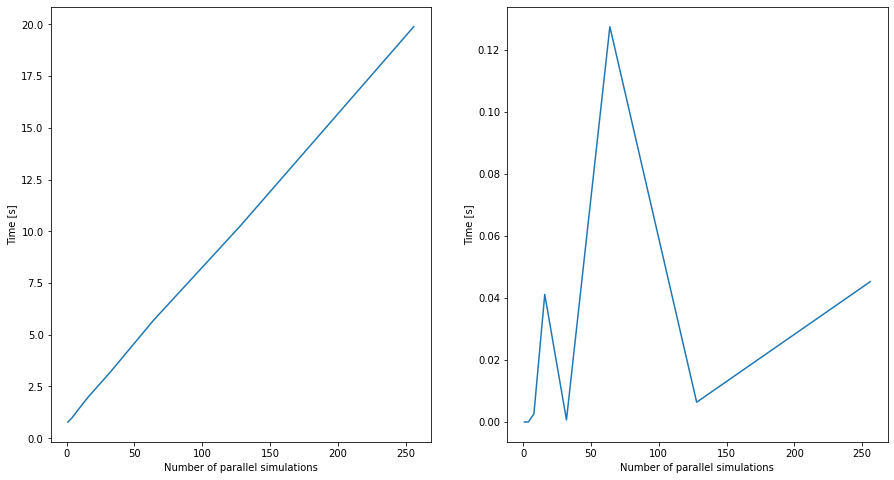

In [5]:
max_num = 9
times = np.zeros((max_num,5))
num_sim_axis = 2**np.arange(max_num)
for i in range(max_num):
  p = parameters[:2**i]
  for j in range(5):
    st = time.time()
    _, _ = simulate_heun_noise(p,length = 302.0, dt=dt, num_sim = 2**i)
    times[i,j] = time.time()-st
mean_times, var_times = np.mean(times, axis = 1), np.var(times, axis = 1)

f = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)
ax.plot(num_sim_axis,mean_times)
plt.xlabel("Number of parallel simulations")
plt.ylabel("Time [s]")

ax = plt.subplot(1,2,2)
ax.plot(num_sim_axis,var_times)
plt.xlabel("Number of parallel simulations")
plt.ylabel("Time [s]")
plt.show()

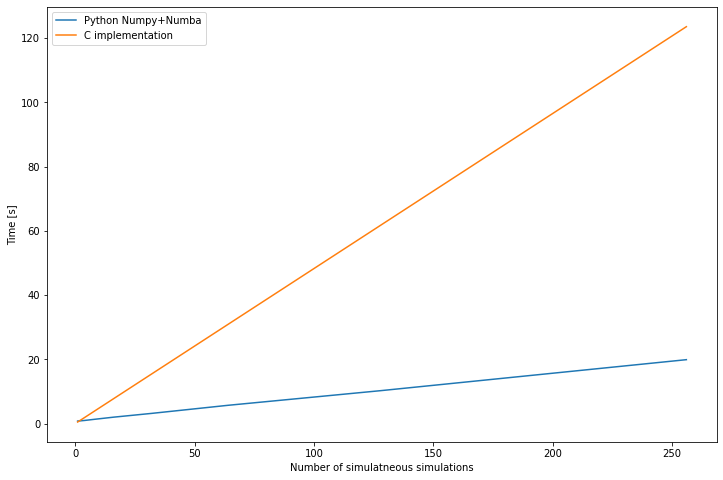

In [8]:
f = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.plot(num_sim_axis,mean_times, label = 'Python Numpy+Numba')
ax.plot(num_sim_axis,num_sim_axis*0.4825, label = 'C implementation')
plt.xlabel("Number of simulatneous simulations")
plt.ylabel("Time [s]")
plt.legend()

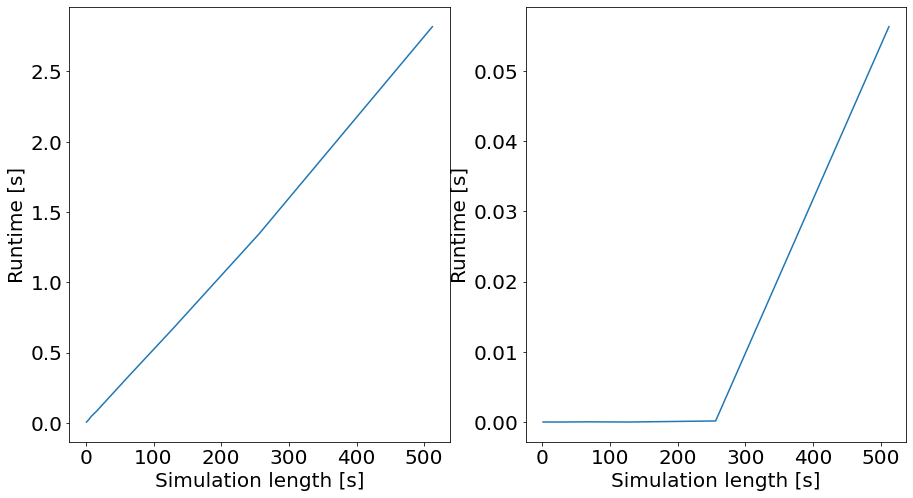

In [22]:
max_num = 10
times = np.zeros((max_num,5))
num_sim_axis = 2**np.arange(max_num)
p = parameters[:1]
for i in range(max_num):
  for j in range(5):
    st = time.time()
    _, _ = simulate_heun_noise(p,length = 2*(2.0**i), dt=dt, num_sim = 1)
    times[i,j] = time.time()-st
mean_times, var_times = np.mean(times, axis = 1), np.var(times, axis = 1)

f = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.plot(num_sim_axis,mean_times)
ax.fill_between(num_sim_axis, mean_times - np.std(times, axis = 1), mean_times + np.std(times, axis = 1),alpha=0.2)
plt.xlabel("Simulation length [s]")
plt.ylabel("Runtime [s]")
plt.show()

In [27]:
C_time = np.array([
[0.003000,0.004000,0.006000,0.007000,0.007000],
[0.013000,0.008000,0.011000,0.013000,0.011000],
[0.020000,0.019000,0.017000,0.015000,0.015000],
[0.029000,0.029000,0.036000,0.032000,0.033000],
[0.063000,0.065000,0.072000,0.102000,0.077000],
[0.117000,0.108000,0.133000,0.117000,0.110000],
[0.219000,0.217000,0.267000,0.222000,0.220000],
[0.437000,0.425000,0.613000,0.433000,0.439000],
[0.990000,0.888000,0.873000,0.851000,0.868000],
[1.793000,1.735000,1.793000,1.751000,1.713000]
])

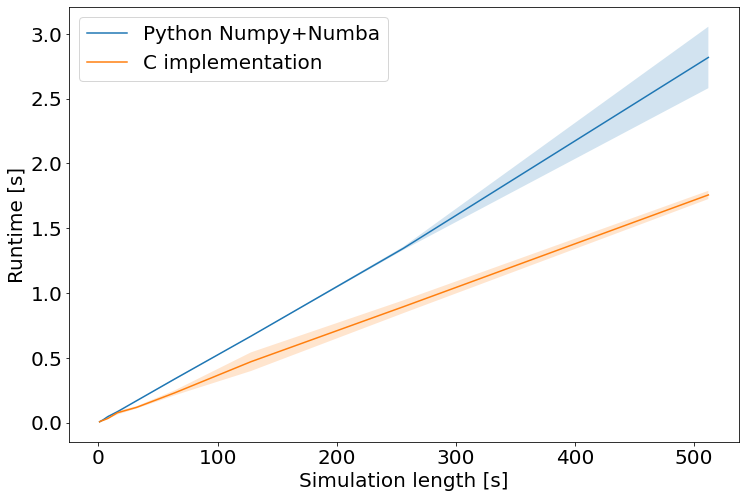

In [28]:
f = plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.plot(num_sim_axis,mean_times, label = 'Python Numpy+Numba')
ax.fill_between(num_sim_axis, mean_times - np.std(times, axis = 1), mean_times + np.std(times, axis = 1),alpha=0.2)
ax.plot(num_sim_axis,C_time.mean(axis=1), label = 'C implementation')
ax.fill_between(num_sim_axis, C_time.mean(axis=1) - np.std(C_time, axis = 1), C_time.mean(axis=1) + np.std(C_time, axis = 1),alpha=0.2)
plt.xlabel("Simulation length [s]")
plt.ylabel("Runtime [s]")
plt.legend()